# Microsoft Stock - Time Series Analysis
The Dataset contains the stock information of Microsoft from 1st April 2015 to 1st April 2021. The Analysis is to predict the number of <b> Shares Traded </b> by creating a model, below mentioned are the steps on which the models is created and how the accuracy is tested.

## 1. IMPORTING THE DATA

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
MSD = pd.read_csv(r"C:\Users\msour\OneDrive\Documents\IVY\Project python ML\Forecasting_Project_Microsoft_Stock.csv")
MSD.head(5)

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438


## 2. BASIC DATA ANALYSIS

In [2]:
MSD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1511 non-null   object 
 1   Open    1511 non-null   float64
 2   High    1511 non-null   float64
 3   Low     1511 non-null   float64
 4   Close   1511 non-null   float64
 5   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 71.0+ KB


In [3]:
MSD.nunique()

Date      1511
Open      1409
High      1400
Low       1397
Close     1398
Volume    1511
dtype: int64

Here, as we can see, that there is no null values in the dataset. Hence, treating missing value is not required. But the Date column in the dataset is stored in object datatype, so we need to treat it, by converting form object type to datetime type. 

In [4]:
#defining a function that converts a date from string to datetime.
def stringtodate(inpstring):
    import datetime
    return (datetime.datetime.strptime(inpstring,"%m/%d/%Y %H:%M:%S"))

In [5]:
MSD["Datetime"] = MSD['Date'].apply(stringtodate)
MSD.head(5)

,Date,Open,High,Low,Close,Volume,Datetime
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322,2015-04-01 16:00:00
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476,2015-04-02 16:00:00
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692,2015-04-06 16:00:00
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375,2015-04-07 16:00:00
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438,2015-04-08 16:00:00


The new Datetime column contains the date in the correct format

## 3. FEATURE ENGINEERING

In [6]:
#Creating a column for month and year. 
import datetime as dt
MSD['Year'] = MSD['Datetime'].dt.year
MSD['Month'] = MSD['Datetime'].dt.month
MSD.tail(5)

,Date,Open,High,Low,Close,Volume,Datetime,Year,Month
1506,3/25/2021 16:00:00,235.30,236.94,231.57,232.34,34061853,2021-03-25 16:00:00,2021,3
1507,3/26/2021 16:00:00,231.55,236.71,231.55,236.48,25479853,2021-03-26 16:00:00,2021,3
1508,3/29/2021 16:00:00,236.59,236.80,231.88,235.24,25227455,2021-03-29 16:00:00,2021,3
1509,3/30/2021 16:00:00,233.53,233.85,231.10,231.85,24792012,2021-03-30 16:00:00,2021,3
1510,3/31/2021 16:00:00,232.91,239.10,232.39,235.77,43623471,2021-03-31 16:00:00,2021,3


## 4. CREATING CROSSTABS TO CREATE THE SERIES

In [7]:
#To predict the total volumes of shares traded, a crosstab is created. 
Total_Shares_Trade = pd.crosstab(columns = MSD["Year"],index = MSD["Month"],values = MSD["Volume"],aggfunc=sum).melt()
TST = Total_Shares_Trade.dropna().reset_index(drop=True)
TST_value = TST['value']

## 5. PLOTTING THE TREND

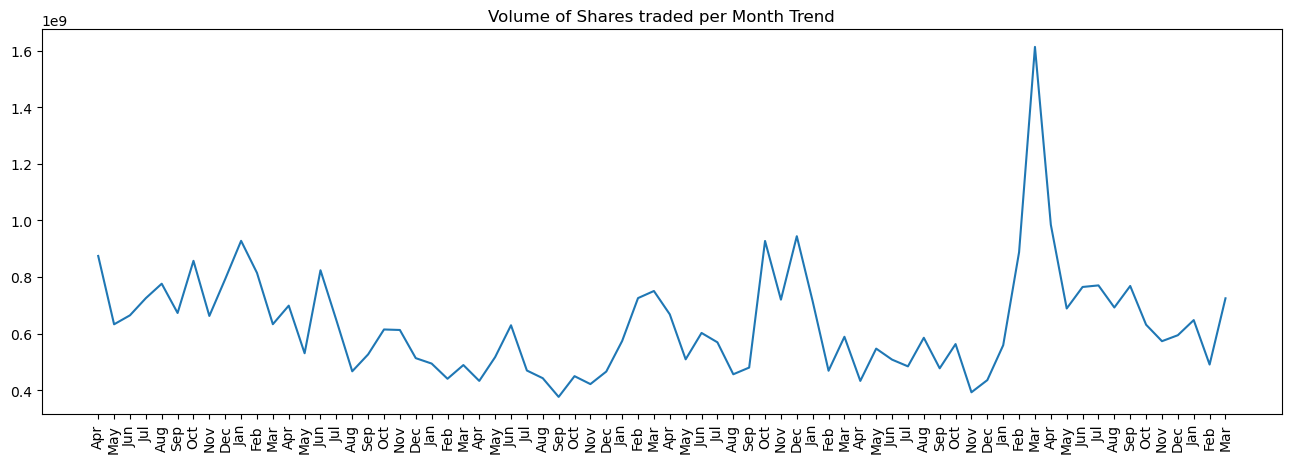

In [8]:
import matplotlib.pyplot as plt
fig ,subplot = plt.subplots(nrows = 1, ncols = 1, figsize = (16,5))
Monthname = ["Apr", "May", "Jun", "Jul", "Aug", "Sep","Oct", "Nov", "Dec", "Jan", "Feb", "Mar"]*6
TST_value.plot(kind = 'line',ax = subplot,title = "Volume of Shares traded per Month Trend")
subplot.set_xticks(range(len(Monthname)));
subplot.set_xticklabels(Monthname, rotation=90);

## 5. PLOTTING THE SEASONALITY, TREND, RESIDUE & OBSERVED PER CYCLE

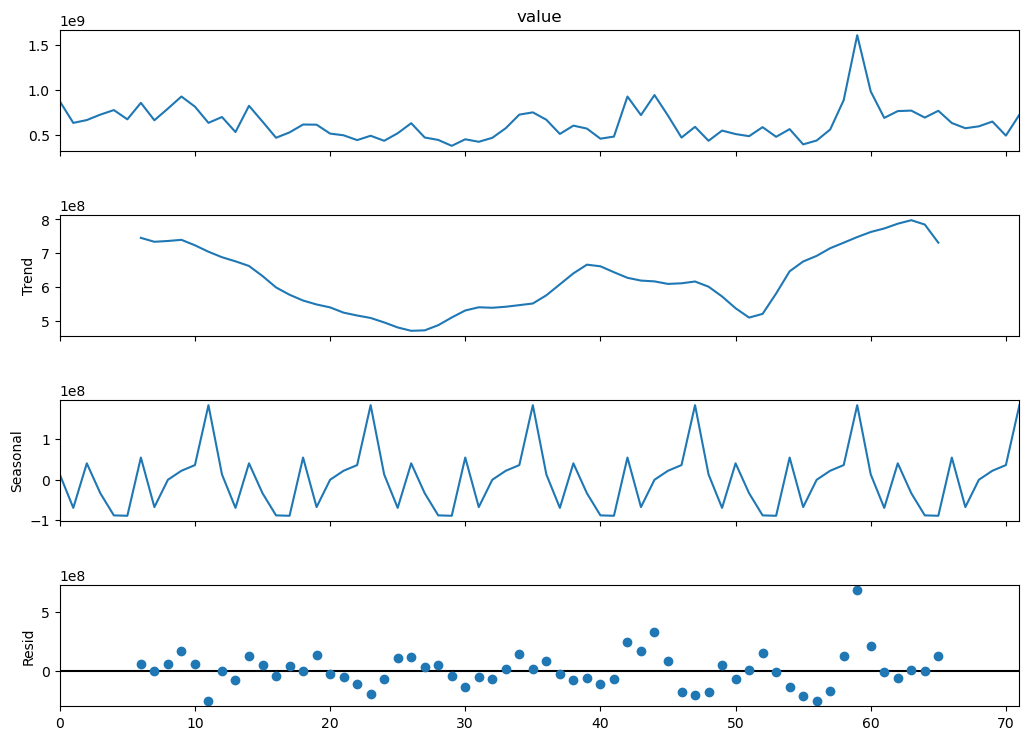

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
result = seasonal_decompose(TST_value,period = 12)
result.plot()
Currentfig = plt.gcf()
Currentfig.set_size_inches(11,8)
plt.show()

## 6. FINDING PARAMETERS FOR SARIMA MODEL AND FORECASTING

In [75]:
def func_tune_arima(inpdata,p_val,d_val,q_val,sp_val,sd_val,sq_val,cycle,month_no,M_name):
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    import pandas as pd
    import numpy as np
    print("----Time Series Forecasting Result----\n")
    #creating a tuning function for the arima to get the best parameters that is p,d,q.
    result = pd.DataFrame()
    for p in p_val:
        for d in d_val:
            for q in q_val:
                for sp in sp_val:
                    for sd in sd_val:
                        for sq in sq_val:
                            try:
                                model = SARIMAX(inpdata,order=(p,d,q),seasonal_order=(sp,sd,sq,cycle))
                                model_fit = model.fit(disp=False)
                                prediction = model_fit.predict(0,len(inpdata)-1)
                                Acc = 1-np.mean(abs(inpdata-prediction)/inpdata)
                                temp_df = pd.DataFrame([[p,d,q,sp,sd,sq,Acc]],columns=["p","d","q","sp","sd","sq","Acc"])
                                result = pd.concat([result,temp_df])
                            except:
                                pass
    max_acc_res = result.sort_values('Acc',ascending=False)
    
    # now as max_acc_res contains the parameters with sorted accuracy only conisdering the parameters for the 
    # top row and inserting in the model.Then predicting for the next n months.
    p_,d_,q_,sp_,sd_,sq_ = max_acc_res.iloc[0, :6]
    print(f"The parameters for the maximum accuracy are P={p_}, D ={d_}, Q={q_}, SP={sp_}, SD={sd_}, SQ={sq_}")
    sarimax_model = SARIMAX(inpdata,order=(p_,d_,q_),seasonal_order=(sp_,sd_,sq_,cycle))
    forecast_model = sarimax_model.fit(disp = False)
    forecast = forecast_model.predict(start=0,end=(len(inpdata)-1)+month_no,typ="levels").rename("Forecast")
    print(f"\nThe forecast for the next {month_no} month would be:")
    print(forecast[-month_no:])
    
    #finding accuracy of the model
    MAPE = np.mean(abs(forecast[:len(inpdata)]-inpdata)/inpdata)
    print("\nAccuracy of the model is: ",round((1-MAPE),4))
    
    #Plotting the forecasting
    import matplotlib.pyplot as plt
    fig, subplot = plt.subplots(nrows=1,ncols=1,figsize=(18,5))
    fig.suptitle(f"Forecasting for the next {month_no} months:", fontsize=16)
    ForecastMonthNames = M_name + M_name[:(month_no)]
    inpdata.plot(kind = 'line',color = "Orange",ax = subplot)
    forecast.plot(kind = 'line',color = "Purple",ax = subplot)
    subplot.set_xticks(range(len(ForecastMonthNames)))
    subplot.set_xticklabels(ForecastMonthNames, rotation=90);

----Time Series Forecasting Result----

The parameters for the maximum accuracy are P=1.0, D =1.0, Q=10.0, SP=2.0, SD=0.0, SQ=0.0

The forecast for the next 6 month would be:
72    6.189025e+08
73    6.668953e+08
74    6.237583e+08
75    6.507046e+08
76    6.266617e+08
77    6.549830e+08
Name: Forecast, dtype: float64

Accuracy of the model is:  0.8347


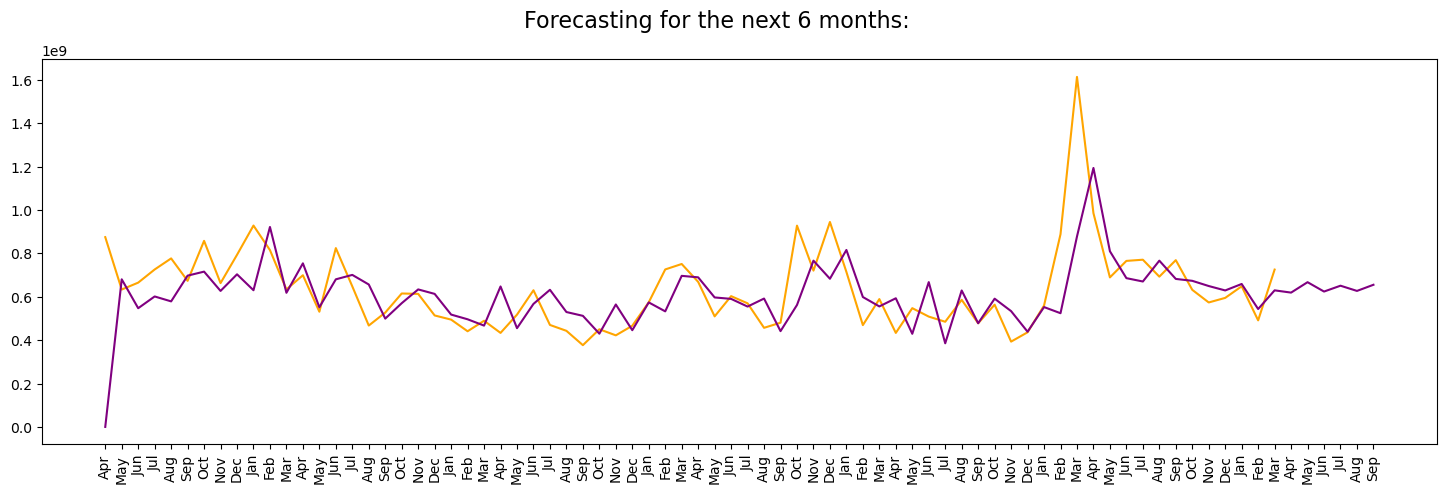

In [76]:
Monthname = ["Apr", "May", "Jun", "Jul", "Aug", "Sep","Oct", "Nov", "Dec", "Jan", "Feb", "Mar"]*6
func_tune_arima(inpdata = TST_value,
                p_val = [0,1], d_val = [0,1], q_val = [1,10],
                sp_val = [1,2], sd_val = [0], sq_val = [0],
                cycle = 12,month_no = 6,M_name = Monthname)